# reg_part_B_NN

# Data import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch

In [2]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [3]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# Artificial Neural Network for Regression

In [4]:
X = data.drop(columns=['time', "DEATH_EVENT"]).values
y = data['time'].values.reshape(-1, 1)

N, M = X.shape

input_dim  = M # M number of features
output_dim = 1 # regression problem

# X.shape, y.shape print shapes of X and y to undestand their dimensions


In [5]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X.shape, y.shape, X_test.shape, y_test.shape, print shapes of X, y, X_test and y_test to understand their dimensions after the split

In [6]:
def get_model(input_dim, hidden_dim, output_dim):
    ### BEGIN SOLUTION
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.Tanh(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer
    )
    ### END SOLUTION

In [7]:
# Normalize data based on training set

def get_fold_data(X, y, train_idx, val_idx):
   
    X_train = X[train_idx]
    X_val   = X[val_idx]
    y_train = y[train_idx]
    y_val   = y[val_idx]

    mean = X_train.mean(axis=0)
    std  = X_train.std(axis=0)

    X_train_norm = (X_train - mean) / std
    X_val_norm   = (X_val   - mean) / std

    return X_train_norm, X_val_norm, y_train, y_val

# Tensor conversion

def torch_tensor_conversion(X_train, y_train, X_val, y_val):

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

Fold 1/10
  Hidden units: 1, Validation set MSE: 5595.1870
  Hidden units: 2, Validation set MSE: 9120.5586
  Hidden units: 4, Validation set MSE: 8524.6182
  Hidden units: 8, Validation set MSE: 7894.6641
  Hidden units: 11, Validation set MSE: 8391.3047
  Hidden units: 14, Validation set MSE: 7904.2798
  Hidden units: 20, Validation set MSE: 6647.6968
  Hidden units: 30, Validation set MSE: 5518.0898
  Hidden units: 40, Validation set MSE: 5748.6914
  Hidden units: 50, Validation set MSE: 7162.7188
  Hidden units: 100, Validation set MSE: 8710.7539
  Hidden units: 200, Validation set MSE: 8312.9307
Fold 2/10
  Hidden units: 1, Validation set MSE: 8219.8936
  Hidden units: 2, Validation set MSE: 8059.8477
  Hidden units: 4, Validation set MSE: 10058.6689
  Hidden units: 8, Validation set MSE: 10411.9717
  Hidden units: 11, Validation set MSE: 9585.1484
  Hidden units: 14, Validation set MSE: 8626.0156
  Hidden units: 20, Validation set MSE: 10938.5859
  Hidden units: 30, Validation se

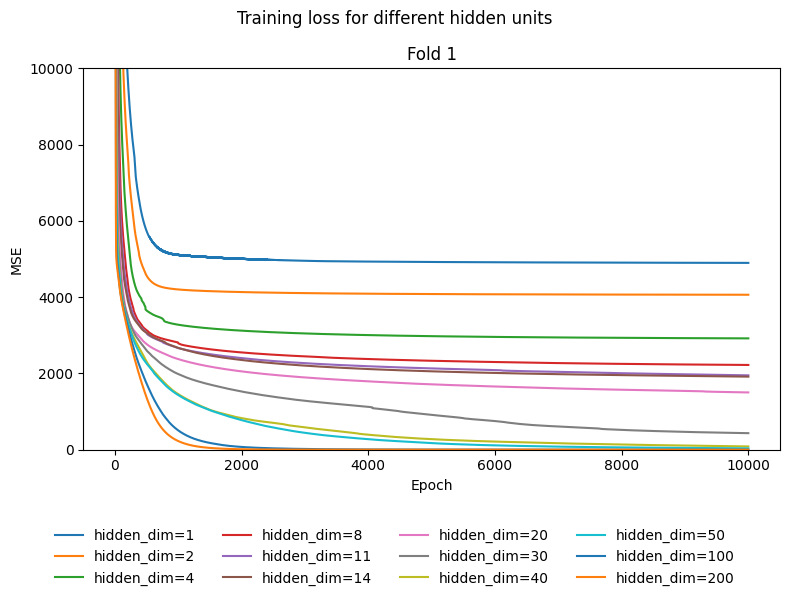

In [107]:
K = 10
CV = KFold(K, shuffle=True, random_state=0)
# initilize lists to store results

# Define hyperparameters
lr = 1e-3 # lr = learning rate: step size used by the optimizer when updating weights.
n_epochs = 10000 # n_epochs = number of times the entire training dataset is passed through the model during training.
momentum= 0

# Seed for reproducibility
seed = 0

# Hyperparameter tuning loop with K-fold crossvalidation
hyperparameters_to_tune = [1, 2, 4, 8, 11, 14, 20, 30, 40, 50, 100, 200]

results = {}

for k, (train_index, val_index) in enumerate(CV.split(X, y)):
    print(f'Fold {k+1}/{K}')

    # Get fold data using the helper function defined above get_fold_data
    X_train, X_val, y_train, y_val = get_fold_data(X, y, train_index, val_index)

    # Convert to torch tensors
    X_train, y_train, X_val, y_val = torch_tensor_conversion(X_train, y_train, X_val, y_val)

    #Set up a dictionary to store the results for each hyperparameter setting
    results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hyperparameters_to_tune}

    # Loop over the hyperparameter settings        
    for hidden_dim in hyperparameters_to_tune:
         # Define a model instance with a specific number of hidden units
         model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

         # Define loss criterion
         criterion = torch.nn.MSELoss()

         # Define the optimizer as the Adam optimizer (not needed to know the details)
         # We need to decide if we want to use gradient descent or stochastic gradient descent with batches
         # Stochastic Gradient Descent is faster for larger datasets
         # The data that we are working with is small so we can use gradient descent
         optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum= momentum) 

         for epoch in range(n_epochs):
            # Set the model to training mode
            model.train()

            # Make a forward pass through the model to compute the outputs
            outputs = model(X_train)
            # Compute the loss
            loss = criterion(outputs, y_train)

            # Make sure that the gradients are zero before you use backpropagation
            optimizer.zero_grad()
            # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
            loss.backward()
            # Update the model parameters by making the optimizer take a gradient descent step
            optimizer.step()

            # Store the training loss for this epoch in the dictionary
            results_inner[hidden_dim]['train'].append(loss.item())

            # Compute the final test loss on the test set
         with torch.no_grad(): # No need to compute gradients for the validation set
            model.eval()
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            results_inner[hidden_dim]['val'].append(val_loss.item())
            print(f'  Hidden units: {hidden_dim}, Validation set MSE: {val_loss.item():.4f}')

    # Store the results for this fold
    results[k] = results_inner


"""fig, axs = plt.subplots(1, K, figsize=(12, 8), sharey=True, sharex=True)
for fold in range(K):
    for hidden_dim in hyperparameters_to_tune:
        axs[fold].plot(results[fold][hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')
    axs[fold].set_title(f'Fold {fold+1}')
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('MSE')
    axs[fold].set_ylim(0, 10000)  # Set x-axis range

plt.suptitle('Training loss for different hidden units')
plt.tight_layout(rect=[0,0.15,1,1])  # Leave space at the bottom for the legend

# Place the legend at the bottom center, spanning all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=4, frameon=False)  # adjust ncol as needed for your number of labels

plt.show()
"""

fig, ax = plt.subplots(figsize=(8, 6))
fold = 0  # select which fold you want to plot (0 for Fold 1)
for hidden_dim in hyperparameters_to_tune:
    ax.plot(results[fold][hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')
ax.set_title(f'Fold {fold+1}')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_ylim(0, 10000)

plt.suptitle('Training loss for different hidden units')
plt.tight_layout(rect=[0,0.15,1,1])

# Place the legend at the bottom center
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4, frameon=False)

plt.show()


In [108]:
K = 10
CV = KFold(K, shuffle=True, random_state=0)
# initilize lists to store results

# Define hyperparameters
lr = 1e-3 # lr = learning rate: step size used by the optimizer when updating weights.
n_epochs = 10000 # n_epochs = number of times the entire training dataset is passed through the model during training.
momentum_list = [0, 0.2, 0.5, 0.9]

# Seed for reproducibility
seed = 0

# Hyperparameter tuning loop with K-fold crossvalidation
hyperparameters_to_tune = [1, 2, 3, 4, 5, 8, 11, 14, 20, 30, 40, 50, 75, 100, 200]

results = {}

for momentum_index in momentum_list:
    momentum = momentum_index
    results_momentum = {}

    for k, (train_index, val_index) in enumerate(CV.split(X, y)):
        print(f'Fold {k+1}/{K}')

        # Get fold data using the helper function defined above get_fold_data
        X_train, X_val, y_train, y_val = get_fold_data(X, y, train_index, val_index)

        # Convert to torch tensors
        X_train, y_train, X_val, y_val = torch_tensor_conversion(X_train, y_train, X_val, y_val)

        #Set up a dictionary to store the results for each hyperparameter setting
        results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hyperparameters_to_tune}

        # Loop over the hyperparameter settings        
        for hidden_dim in hyperparameters_to_tune:
            # Define a model instance with a specific number of hidden units
            model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

            # Define loss criterion
            criterion = torch.nn.MSELoss()

            # Define the optimizer as the Adam optimizer (not needed to know the details)
            # We need to decide if we want to use gradient descent or stochastic gradient descent with batches
            # Stochastic Gradient Descent is faster for larger datasets
            # The data that we are working with is small so we can use gradient descent
            optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum= momentum) 

            for epoch in range(n_epochs):
                # Set the model to training mode
                model.train()

                # Make a forward pass through the model to compute the outputs
                outputs = model(X_train)
                # Compute the loss
                loss = criterion(outputs, y_train)

                # Make sure that the gradients are zero before you use backpropagation
                optimizer.zero_grad()
                # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
                loss.backward()
                # Update the model parameters by making the optimizer take a gradient descent step
                optimizer.step()

                # Store the training loss for this epoch in the dictionary
                results_inner[hidden_dim]['train'].append(loss.item())

                # Compute the final test loss on the test set
            with torch.no_grad(): # No need to compute gradients for the validation set
                model.eval()
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                results_inner[hidden_dim]['val'].append(val_loss.item())
                print(f'  Hidden units: {hidden_dim}, Validation set MSE: {val_loss.item():.4f}')

        # Store the results for this fold
        results_momentum[k] = results_inner

    results[momentum] = results_momentum

Fold 1/10
  Hidden units: 1, Validation set MSE: 5595.1978
  Hidden units: 2, Validation set MSE: 9440.1963
  Hidden units: 3, Validation set MSE: 8724.9834
  Hidden units: 4, Validation set MSE: 7241.4966
  Hidden units: 5, Validation set MSE: 8979.2734
  Hidden units: 8, Validation set MSE: 7045.4165
  Hidden units: 11, Validation set MSE: 8332.6182
  Hidden units: 14, Validation set MSE: 5915.5723
  Hidden units: 20, Validation set MSE: 5751.0386
  Hidden units: 30, Validation set MSE: 8956.8057
  Hidden units: 40, Validation set MSE: 6967.5742
  Hidden units: 50, Validation set MSE: 10225.0068
  Hidden units: 75, Validation set MSE: 6666.0640
  Hidden units: 100, Validation set MSE: 8365.1006
  Hidden units: 200, Validation set MSE: 6684.3374
Fold 2/10
  Hidden units: 1, Validation set MSE: 8219.8457
  Hidden units: 2, Validation set MSE: 8059.5337
  Hidden units: 3, Validation set MSE: 8180.9199
  Hidden units: 4, Validation set MSE: 8981.0137
  Hidden units: 5, Validation set MSE

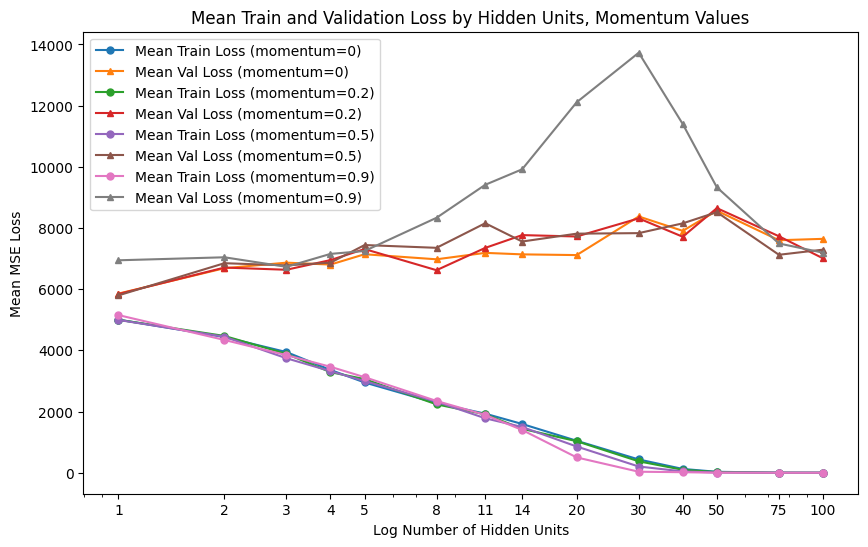

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# results structure: results[momentum][fold][hidden_dim]['train'/val']

# Prepare plot
plt.figure(figsize=(10, 6))

for momentum in momentum_list:
    results_momentum = results[momentum]
    
    # Get all hidden units (assuming same for all)
    hidden_units = list(results_momentum[0].keys())  # Use first fold
    hidden_units.pop(-1)
    
    mean_train_loss = []
    mean_val_loss = []

    for hidden_dim in hidden_units:
        train_values = []
        val_values = []
        for k in results_momentum.keys():  # iterate over folds
            train_values.append(results_momentum[k][hidden_dim]['train'][-1])
            val_values.append(results_momentum[k][hidden_dim]['val'][-1])
        mean_train_loss.append(np.mean(train_values))
        mean_val_loss.append(np.mean(val_values))

    # Line plots, different color/marker for each momentum
    plt.plot(hidden_units, mean_train_loss, marker='o', label=f'Mean Train Loss (momentum={momentum})', markersize=5)
    plt.plot(hidden_units, mean_val_loss, marker='^', label=f'Mean Val Loss (momentum={momentum})', markersize=5)

plt.xlabel('Log Number of Hidden Units')
plt.ylabel('Mean MSE Loss')
plt.title('Mean Train and Validation Loss by Hidden Units, Momentum Values')
plt.xscale('log')
plt.xticks(hidden_units, labels=[str(h) for h in hidden_units])  # Use normal (not scientific) labels
plt.legend()
plt.show()
